In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

**Imports for image reading**

In [ ]:
import PIL
from PIL import Image
from matplotlib import image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.0.0


Imports for modeling:

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_auc_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers 
from tensorflow.keras import Model
from keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# This lets you mount a directory from Google Drive
from google.colab import drive

In [ ]:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
%matplotlib inline

## Target Data (and associated EDA features
---

**Note: According to the README from the original data post, all images have been converted to 1024 X 1024 matrix images, so don't worry about what the origin image pixel sizes are for import.**

This can of course still be useful for EDA (perhaps higher image pixel sizes led to higher incidence of findings?

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path = '/content/gdrive/MyDrive/Colab Notebooks/data/Data_Entry_2017_v2020.csv'

In [ ]:
df = pd.read_csv(path)

In [ ]:
df.columns = df.columns.map({col:col.lower().replace(' ','_') for col in df.columns})

In [ ]:
df.finding_labels[50:55]

50                 Emphysema|Pneumothorax
51               Atelectasis|Pneumothorax
52                           Pneumothorax
53    Cardiomegaly|Emphysema|Pneumothorax
54                             No Finding
Name: finding_labels, dtype: object

In [ ]:
labels = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 
          'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']

In [ ]:
#Trying to reduce the number of unique instances
df['is_positive_finding'] = df.finding_labels.apply(lambda x: 'No Finding' if x == 'No Finding' else 'Positive Finding')

In [ ]:
df.is_positive_finding.value_counts() #112120

No Finding          60361
Positive Finding    51759
Name: is_positive_finding, dtype: int64

Method for building generator and this count are from [this site](https://godatadriven.com/blog/keras-multi-label-classification-with-imagedatagenerator/)

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Positive Finding
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Positive Finding
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Positive Finding
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,No Finding
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Positive Finding
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,Positive Finding
6,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,Positive Finding
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,Positive Finding
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,Positive Finding
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143,Positive Finding


## Image data (Modelling Features)
---

In [ ]:
#making a file patient num and file image num column, then sorting
print(int(df.image_index[0].split('_')[0]))
df['fpt_num'] = df.image_index.apply(lambda x: int(x.split('_')[0]))
df['fimg_num'] = df.image_index.apply(lambda x: int(x.split('_')[1].split('.')[0]))

1


In [ ]:
arranger = df.sort_values(by = ['fpt_num', 'fimg_num']).reset_index()

In [ ]:
arranger.tail(12)

,index,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding,fpt_num,fimg_num
112108,112108,00030795_000.png,Pleural_Thickening,0,30795,52,F,PA,2021,2021,0.194311,0.194311,Positive Finding,30795,0
112109,112109,00030796_000.png,No Finding,0,30796,43,M,PA,2021,2021,0.194311,0.194311,No Finding,30796,0
112110,112110,00030797_000.png,No Finding,0,30797,23,M,PA,2021,2021,0.194311,0.194311,No Finding,30797,0
112111,112111,00030798_000.png,No Finding,0,30798,29,M,PA,2500,2048,0.171000,0.171000,No Finding,30798,0
112112,112112,00030799_000.png,No Finding,0,30799,32,M,PA,2048,2500,0.171000,0.171000,No Finding,30799,0
112113,112113,00030800_000.png,No Finding,0,30800,33,F,PA,2048,2500,0.168000,0.168000,No Finding,30800,0
112114,112114,00030801_000.png,No Finding,0,30801,38,M,PA,2500,2048,0.168000,0.168000,No Finding,30801,0
112115,112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168000,0.168000,Positive Finding,30801,1
112116,112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168000,0.168000,No Finding,30802,0
112117,112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168000,0.168000,No Finding,30803,0


In [ ]:
df = arranger.drop(columns = 'index')
df.drop(columns = ['fpt_num', 'fimg_num'], inplace = True)

In [ ]:
df.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Positive Finding
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Positive Finding
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Positive Finding
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,No Finding
4,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,Positive Finding
5,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Positive Finding
6,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,Positive Finding
7,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,Positive Finding
8,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,Positive Finding
9,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,Positive Finding


It appears that the original indices phased in and out with this new index. That's why my x ray image in my array and my sub list were only off by a few images.

## Getting the Subset Data from the DF
---

In [ ]:
#This function was designed to point my image generator to each specific file, as keras flow from dataframe method does not allow for
#navigating sub-directories
def path_setup():
    path = '/content/gdrive/MyDrive/Capstone_Images/'
    all_dfs = []
    midpath = ['images/', 'images_5/', 'images_6/', 'images_7/', 'images_8/', 
               'images_9/','images_10/','images_11/', 'images_12/']
    
    low = ['000000001_000.png', '00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png',
          '00018387_035.png', '00020945_050.png','00024718_000.png','00028173_003.png']
    high = ['00010927_001.png','00011558_008.png','00013774_026.png','00016051_010.png','00018387_035.png',
           '00020945_050.png','00024718_000.png','00028173_003.png','00030805_000.png']
    
    for i,j,k in zip(low, high, midpath):
        if i == '000000001_000.png':
            df_sub = df.iloc[: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        elif j == '00030805_000.png':
            df_sub = df.iloc[df[df.image_index == i].index.values[0]:]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
            
        else:
            df_sub = df.iloc[df[df.image_index == i].index.values[0]: df[df.image_index == j].index.values[0]]
            df_sub['path'] = df_sub.image_index.apply(lambda x: path + k + x)
            all_dfs.append(df_sub)
    
    new_df = pd.concat(all_dfs)
    print(len(all_dfs) == 9)
    return new_df

In [ ]:
df_sub = path_setup()

True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
df_sub.tail()

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding,path
112115,00030801_001.png,Mass|Pneumonia,1,30801,38,M,PA,2048,2500,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112116,00030802_000.png,No Finding,0,30802,28,M,PA,2048,2500,0.168,0.168,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112118,00030804_000.png,No Finding,0,30804,29,F,PA,2048,2500,0.168,0.168,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
112119,00030805_000.png,No Finding,0,30805,26,M,PA,2048,2500,0.171,0.171,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...


In [ ]:
#I created a test subset of groupings from each folder of data to begin models. The following code is how I achieved this.
# #A list of start and end + 1 indices of the subset of images (slicing will not be inclusive)
# indices = [[0, 407], [4999, 5366], [14999, 15492], [24999, 25791], [34999, 35353],
#           [44999, 45516], [54999, 55376], [64999, 65502], [74999, 75335], [84999, 85444],
#           [94999, 95116], [104999, 105280]]

In [ ]:
# #Confirming that these match the first and last entries in my subset folders
# for i in indices:
#     print(df.loc[i[0]].image_index, df.loc[i[1] - 1].image_index)

In [ ]:
# list_dfs = []
# for ind in indices:
#     list_dfs.append(df.iloc[ind[0]:ind[1]])

In [ ]:
# df_sub = pd.concat(list_dfs)

In [ ]:
#I have verified that each subset of image indices matches what is in my folders
df_sub.head(12)

,image_index,finding_labels,follow-up_#,patient_id,patient_age,patient_gender,view_position,originalimage[width,height],originalimagepixelspacing[x,y],is_positive_finding,path
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171,No Finding,/content/gdrive/MyDrive/Capstone_Images/images...
4,00000003_000.png,Hernia,7,3,81,F,PA,2582,2991,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
5,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
6,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
7,00000003_003.png,Hernia|Infiltration,2,3,76,F,PA,2698,2991,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
8,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...
9,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143,Positive Finding,/content/gdrive/MyDrive/Capstone_Images/images...


In [ ]:
df_sub.shape[0]

112120

In [ ]:
df_sub.shape[0] / df.shape[0]

1.0

EXCELLENT! Now I can model

## Model of Subset Data
---

The goal here, as from [this article](https://medium.com/@ckyeungac/a-simple-trick-about-multi-label-image-classification-with-imagedatagenerator-in-keras-4ab95364a481), is to find a way to one hot encode my labels and keep them. The stroke of genius is to pass the indices as y column in flow, then go back and retrieve the labels.

In [ ]:
print(labels)

['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia', 'No Finding']


In [ ]:
df_flow = df_sub[['path', 'is_positive_finding']].reset_index()
df_flow['index'] = df_flow.index

In [ ]:
df_flow.head()
df_flow = df_flow.sample(frac = 0.5)

In [ ]:
fullpath = '/content/gdrive/MyDrive/Capstone_Images/images'

In [ ]:
#path = '/content/gdrive/MyDrive/Capstone_Images/test_dir'  vertical_flip = True,
datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2,  horizontal_flip = True, rotation_range = .3)

In [ ]:
training = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'is_positive_finding',
                                    class_mode = 'binary', seed = 42,
                                    subset = 'training',
                                   batch_size = 16, target_size = (224, 224),# increase input size when resources allow!
                                   color_mode = 'rgb')

Found 43187 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2077 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
test = datagen.flow_from_dataframe(dataframe = df_flow, directory = None,
                                   x_col = 'path', y_col = 'is_positive_finding',
                                    class_mode = 'binary', seed = 42,
                                    subset = 'validation',
                                   batch_size = 16, target_size = (224, 224),
                                   color_mode = 'rgb')

Found 10796 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2077 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
training.n, test.n

(43187, 10796)

In [ ]:
df_flow

,index,path,is_positive_finding
91827,91827,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
104620,104620,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
84209,84209,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
98735,98735,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
61643,61643,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
...,...,...,...
47602,47602,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
46940,46940,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding
98688,98688,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding
78104,78104,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding


In [ ]:
final_labels = ['No Finding', 'Positive Finding']
final_labels

['No Finding', 'Positive Finding']

In [ ]:
#Before using the ImageDataGenerator, this is how I extracted my original classes from predictions of 15 0s and 1s
def make_preds(arr):
    final_list = []
    for pred in range(len(arr)):
        dictest = {val:arr[pred][ind] for ind,val in enumerate(final_labels)}
        ret_list = [i for i in dictest.keys() if dictest[i] != 0]
        final_list.append(ret_list)
    return final_list

In [ ]:
#This tells Keras how many steps to take for each epoch, since the batch size is defined outside of the model
step_train=training.n//training.batch_size
step_test=test.n//test.batch_size

In [ ]:
#Base model imported from Keras - frozen for transfer learning, fully unfrozen for training from scratch
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights=None,#'imagenet',
    classes = 2,
    pooling = 'avg',
    input_shape=(224, 224, 3)#(1024, 1024, 3)
)

In [ ]:
# base_model.trainable = True

In [ ]:
#Base model outputs --> variable x. Layers added to x, then a new model concatenates them
x=base_model.output
x=Flatten()(x) 

#x=Dense(10024,activation='relu')(x)
#x=Dense(10024,activation='relu')(x)
x=Dense(2024,activation='relu')(x) #we add dense layers so that the model can learn more 
#complex functions and classify for better results.
x=Dense(1024,activation='relu')(x)

#x=Dense(724,activation='relu')(x) #dense layer 2

x=Dense(512,activation='relu')(x) #dense layer 3

#Don't use dropout anymore. Instead, do data augmentation by rotating/flipping your images!

In [ ]:

x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
epoch = 10
cnn_path = '/content/gdrive/MyDrive/cnn_weights/binary_train/'

#save the model weights in case they improve
model_checkpoint_callback = ModelCheckpoint(
    filepath = cnn_path,
    save_weights_only=True,
    monitor='val_loss',#'loss,
    mode='min',
    save_freq = 'epoch', #300,
    save_best_only=True,
    verbose = 1)

In [ ]:
model.load_weights(cnn_path) #--> will load in the model weights after you have made some

result = model.fit(training, steps_per_epoch = step_train, 
                    validation_data = test, 
                      validation_steps= step_test, epochs = epoch, callbacks = model_checkpoint_callback )

Epoch 1/10
2698/2698 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.7055
Epoch 00001: val_loss improved from inf to 0.58877, saving model to /content/gdrive/MyDrive/cnn_weights/binary_train/
2698/2698 [==============================] - 26318s 10s/step - loss: 0.5828 - accuracy: 0.7055 - val_loss: 0.5888 - val_accuracy: 0.6996
Epoch 2/10
2698/2698 [==============================] - ETA: 0s - loss: 0.5799 - accuracy: 0.7084
Epoch 00002: val_loss did not improve from 0.58877
2698/2698 [==============================] - 1690s 626ms/step - loss: 0.5799 - accuracy: 0.7084 - val_loss: 0.5936 - val_accuracy: 0.6921
Epoch 3/10
2698/2698 [==============================] - ETA: 0s - loss: 0.5762 - accuracy: 0.7106
Epoch 00003: val_loss did not improve from 0.58877
2698/2698 [==============================] - 1607s 596ms/step - loss: 0.5762 - accuracy: 0.7106 - val_loss: 0.6021 - val_accuracy: 0.6877
Epoch 4/10
2698/2698 [==============================] - ETA: 0s - loss: 0

In [ ]:
model.save('/content/gdrive/MyDrive/saved_models/binary')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/saved_models/binary/assets


## Model Performances
---
BASELINE = 53.8%

**VGG - 16 frozen:**
- train layers = False
- weights = None
- one dense layer, 212 neurons, dropout of 0.2
- Final training accuracy after 10 epochs: 63.27%
- Final test accuracy after 10 epochs: 62.52% accuracy
- train loss: .6439 || test loss: .6252

**VGG Full Trained:**
- failed to perform above baseline after 10 epochs

**MobileNet:**
- train layers [:20] False, [20:] True
- weights = imagenet
- 4 dense layers: 2024, 1024, 512, 1
- Train final: 86.07% Test final: 62.71%



In [ ]:
#This may show errors below if the GPU instance is killed prior to the model finishing its run
train_loss = result.history['loss']
test_loss = result.history['val_loss']

plt.figure(figsize = (12, 10))

plt.plot(train_loss, color = 'skyblue', label = 'Training Loss')
plt.plot(test_loss, color = 'orange', label = 'Testing Loss')

plt.title('Loss scores of Train and Test by Epoch - Full Train: DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

NameError: ignored

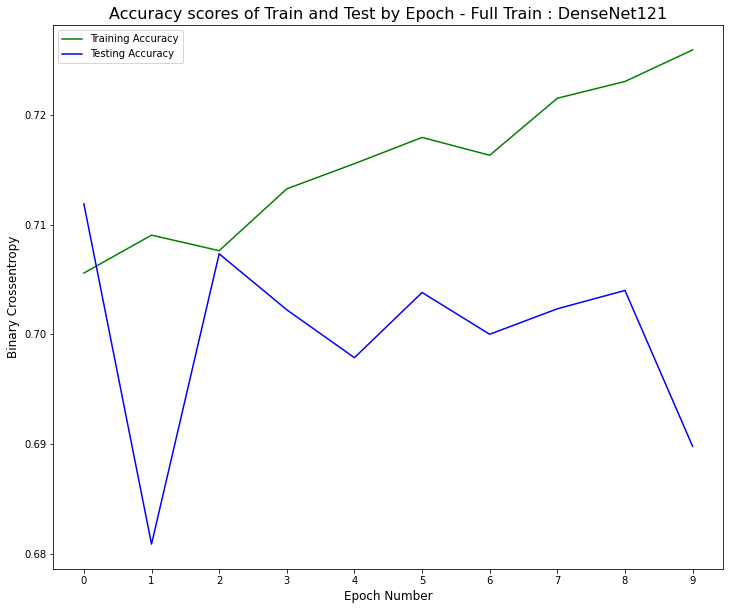

In [ ]:
train_acc = result.history['accuracy']
test_acc = result.history['val_accuracy']

plt.figure(figsize = (12, 10))

plt.plot(train_acc, color = 'green', label = 'Training Accuracy')
plt.plot(test_acc, color = 'blue', label = 'Testing Accuracy')

plt.title('Accuracy scores of Train and Test by Epoch - Full Train : DenseNet121', fontsize = 16)
plt.xlabel('Epoch Number', fontsize = 12)
plt.ylabel('Binary Crossentropy', fontsize = 12)
plt.xticks(np.arange(epoch), np.arange(epoch))

plt.legend();

In [ ]:
pred_classes = (model.predict(training) > 0.5).astype("int32")

In [ ]:
pred_classes[0].shape

(1,)

In [ ]:
final_labels = [i for i in training.class_indices.keys()]

In [ ]:
pred_classes[:5]

array([[1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
test_probas = model.predict(test)

In [ ]:
test_preds = (model.predict(test) >= 0.5).astype("int32")

In [ ]:
test_preds[:5]

array([[0],
       [0],
       [1],
       [1],
       [1]], dtype=int32)

In [ ]:
training.class_indices

{'No Finding': 0, 'Positive Finding': 1}

In [ ]:
training.index_array

array([   81, 30633, 16378, ..., 41226, 11099, 13254])

In [ ]:
df_eval = df_flow.iloc[training.index_array]

In [ ]:
df_eval['model_predictions'] = pred_classes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_eval.model_predictions = df_eval.model_predictions.apply(lambda x: 'No Finding' if x == 0 else "Positive Finding")


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_eval.head(40)

,index,path,is_positive_finding,model_predictions
70052,70052,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding
110836,110836,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,No Finding
79952,79952,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding
90406,90406,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding
59606,59606,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,No Finding
103900,103900,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding
103246,103246,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding
93420,93420,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
102033,102033,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
90693,90693,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding


In [ ]:
df_eval_test = df_flow.iloc[test.index_array]

In [ ]:
df_eval_test['model_predictions'] = test_preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_eval_test.model_predictions = df_eval_test.model_predictions.apply(lambda x: 'No Finding' if x == 0 else "Positive Finding")


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_eval_test['y_true'] = df_eval_test.is_positive_finding.apply(lambda x: int(x == 'Positive Finding'))
df_eval_test['y_probas'] = test_probas

In [ ]:
df_eval_test.head(40)

,index,path,is_positive_finding,model_predictions
81968,81968,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,No Finding
57397,57397,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,No Finding
100410,100410,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
12896,12896,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
94231,94231,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
23303,23303,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
79676,79676,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
21237,21237,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
38336,38336,/content/gdrive/MyDrive/Capstone_Images/images...,No Finding,Positive Finding
88842,88842,/content/gdrive/MyDrive/Capstone_Images/images...,Positive Finding,Positive Finding


In [ ]:
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()

In [ ]:
cm = confusion_matrix(df_eval_test.is_positive_finding, df_eval_test.model_predictions)

From [deeplizard](https://deeplizard.com/learn/video/km7pxKy4UHU)


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['No Finding','Positive Finding']

Normalized confusion matrix
[[0.4484059  0.5515941 ]
 [0.45062475 0.54937525]]


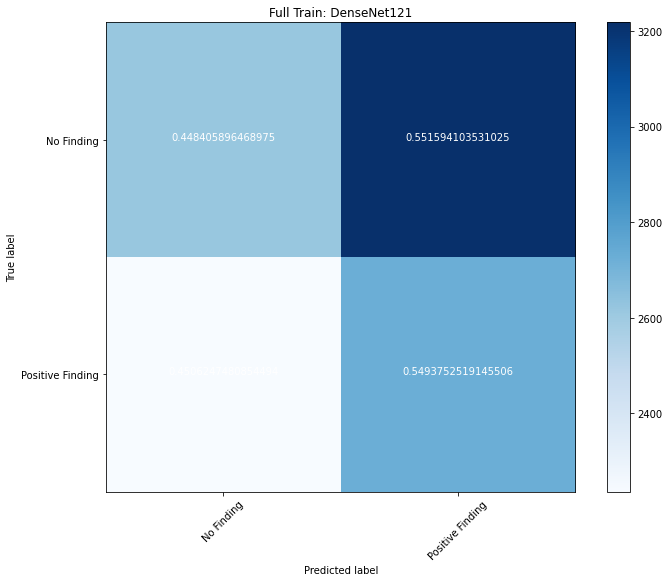

In [ ]:
plt.figure(figsize = (10,8))
plot_confusion_matrix(cm = cm, classes = cm_plot_labels, normalize = True, title = 'Full Train: DenseNet121');

Most recently run (after the presentation) shows a higher sensitivity rate! As I work to further improve these scores in the coming weeks, I will need to be mindful that a model that could be put in production for radiology assistance should probably prioritize sensitivity (recall) - we would want radiologists who see a positive finding flag to be confident that this flag carries actionable meaning for them.